# Diabetes prediction: random forest

## Notebook set-up

In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform, loguniform
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

import configuration as config
import functions as funcs

## 1. Data loading

### 1.1. Load data from disk

Load the pre-processed data from the decision tree notebook:

In [3]:
with open(config.DATA_FILE, 'rb') as input_file:
    dataset = pickle.load(input_file)

training_df = dataset['training']
testing_df = dataset['testing']

### 1.2. Inspect

In [4]:
trd = training_df.head()
trd

ted = testing_df.head()
ted

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
140,3,128.0,78.0,NaN,NaN,21.1,0.268,55,0
610,3,106.0,54.0,21.0,158.0,30.9,0.292,24,0
309,2,124.0,68.0,28.0,205.0,32.9,0.875,30,1
56,7,187.0,68.0,39.0,304.0,37.7,0.254,41,1
742,1,109.0,58.0,18.0,116.0,28.5,0.219,22,0


## 2. Model training

In [5]:
cross_val_scores = {
    'Model': [],
    'Score': []
}

### 2.1. Baseline

Load and score the decision tree model from the first notebook:

In [6]:
with open(config.DECISION_TREE_MODEL, 'rb') as input_file:
    model = pickle.load(input_file)

# Your code here

# Separate features and labels
X_train = training_df.drop(columns=['Outcome'])  
y_train = training_df['Outcome']

X_test = testing_df.drop(columns=['Outcome'])
y_test = testing_df['Outcome']

# Evaluate on training data
train_score = model.score(X_train, y_train)
# Evaluate on testing data
test_score = model.score(X_test, y_test)

print(f"Baseline Decision Tree R² (training): {train_score:.4f}")
print(f"Baseline Decision Tree R² (testing): {test_score:.4f}")

# Add to cross-validation scores
cross_val_scores['Model'].append('Decision Tree Baseline')
cross_val_scores['Score'].append(test_score)


Baseline Decision Tree R² (training): 0.7891
Baseline Decision Tree R² (testing): 0.7188


### 2.2. Random forest model

Score a random forest model:

In [7]:
# Your code here

from sklearn.metrics import accuracy_score

# Separate features (X) and target (y)
X_train = training_df.drop(columns=['Outcome'])
y_train = training_df['Outcome']

X_test = testing_df.drop(columns=['Outcome'])
y_test = testing_df['Outcome']

# Create and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,  
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Random Forest Training Accuracy: {train_accuracy:.4f}")
print(f"Random Forest Testing Accuracy: {test_accuracy:.4f}")

Random Forest Training Accuracy: 1.0000
Random Forest Testing Accuracy: 0.7474


## 3. Hyperparameter optimization

### 3.1. Hyperparameter grid search

In [9]:
# Your code here
hyperparameters = {
    'n_estimators': randint(2, 200),
    'criterion':['gini','entropy','log_loss'],
    'max_depth':randint(1, 20),
    'min_weight_fraction_leaf':loguniform(10**-5, 0.5),
    'max_features':uniform(loc=0.1, scale=0.9),
    'min_impurity_decrease':loguniform(10**-5, 1.0),
    'ccp_alpha':loguniform(10**-5, 1.0)
}

search = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced'),
    hyperparameters,
    return_train_score=True,
    cv=3,
    n_jobs=-1,
    n_iter=1000
)
search_results = search.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
best_model = search_results.best_estimator_
hyperparameters = search_results.best_params_

print('Best hyperparameters:\n')

for key, value in hyperparameters.items():
    print(f' {key}: {value}')

print()


Best hyperparameters:

 ccp_alpha: 0.0072782341451888095
 criterion: entropy
 max_depth: 6
 max_features: 0.5884799331559293
 min_impurity_decrease: 0.0004420396063608632
 min_weight_fraction_leaf: 0.0011053595195465934
 n_estimators: 137



### 3.2. Hyperparameter optimization results

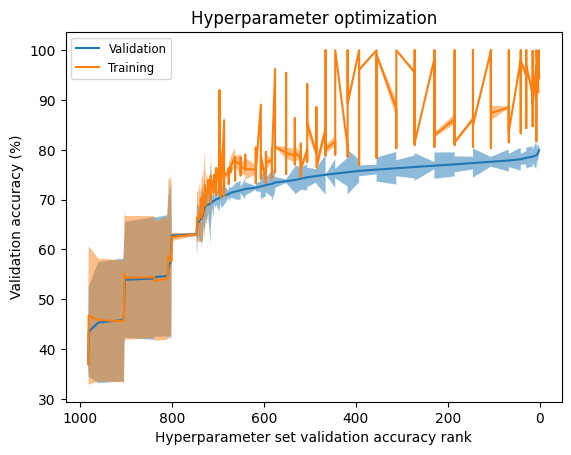

In [10]:
funcs.plot_cross_validation(search_results)

### 3.3. Cross-validation of optimized model

In [12]:
# Your code here

from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(
    best_model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Optimized Random Forest'] * len(scores))
cross_val_scores['Score'].extend(scores * 100)

print(
    f'Optimized random forest cross-validation accuracy: '
    f'{np.mean(scores) * 100:.1f} +/- {np.std(scores) * 100:.1f}%'
)


Optimized random forest cross-validation accuracy: 76.3 +/- 6.2%


## 4. Evaluation

### 4.1. Model comparison

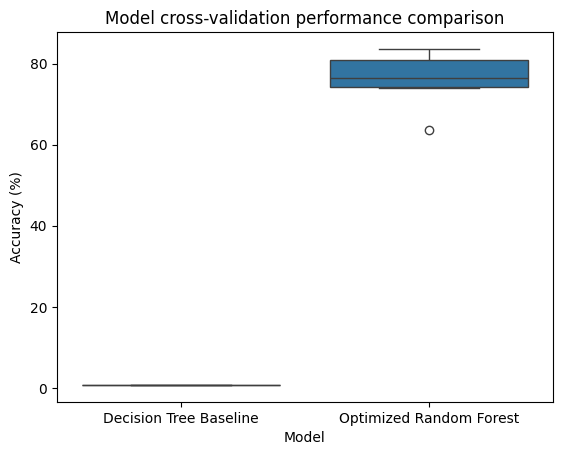

In [14]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Model cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.show()

### 4.2. Test set performance

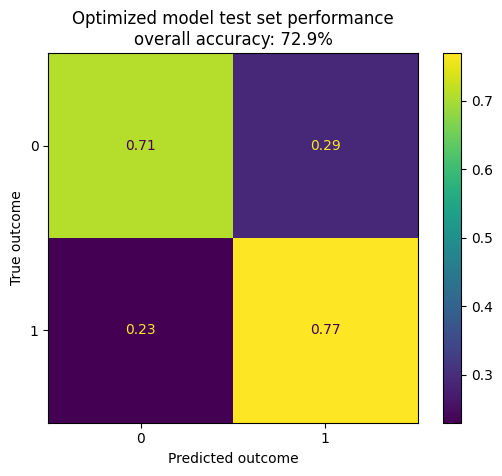

In [16]:
# Evaluate the model on the test set
testing_predictions = best_model.predict(testing_df.drop('Outcome', axis=1))
accuracy = accuracy_score(testing_predictions, testing_df['Outcome']) * 100

# Plot the confusion matrix
cm = confusion_matrix(testing_df['Outcome'], testing_predictions, normalize='true')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
_= cm_disp.plot()

plt.title(f'Optimized model test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted outcome')
plt.ylabel('True outcome')
plt.show()


## 5. Save

### 5.1. Optimized hyperparameters

In [17]:
with open(config.RANDOM_FOREST_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(hyperparameters, output_file)

### 6.2. Model

In [18]:
with open(config.RANDOM_FOREST_MODEL, 'wb') as output_file:
    pickle.dump(model, output_file)